In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import zscore
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.impute import SimpleImputer

# Load the training data into a DataFrame
training_data = pd.read_csv('training_data.csv', sep=';')
training_data = training_data.replace(',', '.', regex=True)

In [ ]:
def clean(data):
  data = data.replace(',', '.', regex=True)

  new_df = data.copy()
  updated_df = new_df.drop(['Group', 'Class', 'Perform'], axis=1)
  new1_df = updated_df.copy()

  for column in updated_df.columns:
      pd.to_numeric(new_df[column], errors='raise', downcast= 'float')

      na_counts = new_df[column].isna().sum() + (new_df[column] == '').sum()

      if na_counts > 1000:
        new1_df = new1_df.drop(column, axis = 1)

  new2_df = new1_df.copy()
  new2_np = new2_df.to_numpy()

  output = data[['Group','Class','Perform']].copy()
  output['Perform'] = output['Perform'].astype(float)
  output_np = output.to_numpy()
  float_arr = new2_np.astype(float)
  i = 0
  na_counts_row = np.zeros(np.size(new2_np,0))
  indices = []
  for row in range(np.size(new2_np,0)):
      na_counts = 0
      for column in range(np.size(new2_np,1)):
          if (np.isnan(float_arr[row,column])):
            na_counts = na_counts + 1
      na_counts_row[row] = na_counts
      if na_counts_row[row] > 20:
        indices = np.append(indices, row)
        i = i + 1

  indices = indices.astype(int)
  rowcleaned = np.delete(float_arr, indices, axis = 0)
  output_ind = np.delete(output_np, indices, axis = 0)

  cleaned_df_temp = pd.DataFrame(rowcleaned, columns = new2_df.columns)
  for col in cleaned_df_temp.columns:
    if cleaned_df_temp[col].dtype in ['float64', 'int64']:
        cleaned_df_temp[col].fillna(cleaned_df_temp[col].mean(), inplace=True)

  z_scores = cleaned_df_temp.apply(zscore)
  threshold = 8

  mask = (z_scores < threshold) & (z_scores > -threshold)
  data_clean_no_outliers = cleaned_df_temp[mask.all(axis=1)]

  resized_df = data_clean_no_outliers.reset_index(drop=True)
  scaler = StandardScaler()
  scaled_array = scaler.fit_transform(resized_df)
  scaled_data = pd.DataFrame(scaled_array, columns=resized_df.columns)

  output_df = pd.DataFrame(output_ind, columns = output.columns)
  output_no_outliers = output_df[mask.all(axis=1)]
  resized_output = output_no_outliers.reset_index(drop=True)
  cleaned_df = pd.concat([scaled_data, resized_output], axis=1)

  return cleaned_df

In [ ]:
def preprocess_features(data):
    # Copy the dataset to avoid changing the original data
    df = data.copy()

    # Weights should sum to 1 and reflect the importance of each indicator
    weights_profitability = [0.25, 0.25, 0.25, 0.25]  # H aypothetical weights for I1, I2, I3, I4
    df['Profitability_composite'] = df[['I1', 'I2', 'I3', 'I4']].dot(weights_profitability)

    # Handling missing values before PCA to avoid NaN issues
    pca_columns = ['I22', 'I23', 'I24', 'I25', 'I26']

    # Applying PCA
    pca = PCA(n_components=1)
    df['Operational_efficiency'] = pca.fit_transform(df[pca_columns])

    # Factor Analysis for Liquidity Composite
    factor_columns = ['I51', 'I53']
    factor = FactorAnalysis(n_components=1)
    df['Liquidity_composite'] = factor.fit_transform(df[factor_columns])

    # Normalization and summation for Valuation Composite
    valuation_columns = ['I39', 'I40', 'I41', 'I42', 'I43']
    df[valuation_columns] = df[valuation_columns].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    df['Valuation_composite'] = df[valuation_columns].sum(axis=1)

    return df

In [ ]:
import sklearn

def _FEDCIS_accuracy_mod(y_true, y_pred):
    res = np.zeros(len(y_pred))
    for i in range(len(y_pred)):
        p = y_pred[i]

        gt = y_true.values[i]

        if p == gt:
            res[i] = 0
        elif p == 0 and (gt == -1 or gt == 1):
            res[i] = 1
        elif (p == 1 or p == -1) and gt == 0:
            res[i] = 1
        elif p == -1 and gt == 1:
            res[i] = 2
        elif p == 1 and gt == -1:
            res[i] = 2

    fedcsis = np.mean(res)
    fedcsis_mod = (2 - fedcsis)/2
    return fedcsis_mod

CUSTOM_FEDCSIS_score = sklearn.metrics.make_scorer(_FEDCIS_accuracy_mod) # the callable scoring object for the gridsearch optimizer

def deconvert_fedcsis_mod(fedcsis_mod):
    fedcsis = 2-(fedcsis_mod * 2)
    return fedcsis

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.7 MB/s eta 0:00:00


In [ ]:
letshopefinal = clean(training_data)
letshopefinal = preprocess_features(letshopefinal)
print(letshopefinal)
letshopefinal = letshopefinal.drop(['I1', 'I7', 'I13', 'I33', 'I34', 'dI33', 'Profitability_composite','Operational_efficiency'], axis = 1)

            I1        I2        I3        I4        I5        I6        I7  \
0     0.030155 -0.180103 -0.182526 -0.241531  0.135693 -0.334285 -0.661977   
1    -0.948806 -0.460154 -0.452350 -0.906280  0.127997  0.365323 -0.009145   
2    -0.006316 -0.379472 -0.456308  0.762760  0.719698  1.505333  1.039726   
3    -0.739818  0.266206  0.073061  1.571277 -0.051005  0.305361 -0.123578   
4    -0.357867  0.066974 -0.164447 -1.012060  1.909993 -2.944796  0.597591   
...        ...       ...       ...       ...       ...       ...       ...   
6980  1.025743  0.019752 -0.105365  1.307125 -0.163756  2.351222  1.940410   
6981 -0.726400 -0.381193 -0.362882 -0.934276 -0.442584 -1.928828  1.290099   
6982  0.244967 -0.234158 -0.323531 -0.091940 -0.174724  0.591950  0.054922   
6983  1.120588 -0.181490 -0.355751 -0.179885 -2.053991  0.564897  0.105031   
6984  0.302516 -0.218206 -0.263275  0.828267 -0.159323 -0.133556 -0.727728   

            I8        I9       I10  ...      dI56      dI57    

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import VotingRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Separate features and target variables
X = letshopefinal.drop(columns=['Perform', 'Class', 'Group'])
y_class = letshopefinal['Class']
y_perform = letshopefinal['Perform']

# Split data for predicting 'Perform'
X_train_perf, X_test_perf, y_train_perf, y_test_perf = train_test_split(X, y_perform, test_size=0.25, random_state=42)

# Initialize models for regression
xgb_model_reg = XGBRegressor()
catboost_model_reg = CatBoostRegressor(verbose=0)

#Define larger parameter grids for regression
param_grid_xgb_reg = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

param_grid_catboost_reg = {
    'iterations': [100, 200, 300],
    'depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Grid search for each regression model
grid_xgb_reg = GridSearchCV(XGBRegressor(), param_grid_xgb_reg, cv=3, n_jobs=-1)
grid_catboost_reg = GridSearchCV(CatBoostRegressor(verbose=0), param_grid_catboost_reg, cv=3, n_jobs=-1)

# Fit grid search for regression
grid_xgb_reg.fit(X_train_perf, y_train_perf)
grid_catboost_reg.fit(X_train_perf, y_train_perf)

# Best estimators for regression
best_xgb_reg = grid_xgb_reg.best_estimator_
best_catboost_reg = grid_catboost_reg.best_estimator_

# Create a voting regressor
ensemble_regressor = VotingRegressor(estimators=[
    ('xgb', best_xgb_reg),
    ('catboost', best_catboost_reg)
])

# Train the ensemble regressor
ensemble_regressor.fit(X_train_perf, y_train_perf)

# Predict 'Perform' on the test set
y_pred_perf = ensemble_regressor.predict(X_test_perf)

# Evaluate the regression model
print("Mean Squared Error for Perform prediction:", mean_squared_error(y_test_perf, y_pred_perf))

# Add predicted 'Perform' to the feature set for classification
X['Predicted_Perform'] = ensemble_regressor.predict(X)


Mean Squared Error for Perform prediction: 0.020157948520256642


In [ ]:
import numpy as np
import pandas as pd

y_class = letshopefinal['Class']
y_perform = letshopefinal['Perform']

y_class = pd.to_numeric(y_class, errors='coerce')
y_perform = pd.to_numeric(y_perform, errors='coerce')

# Converting the columns to numpy arrays
a = y_class.to_numpy()
b = y_perform.to_numpy()

corr = np.corrcoef(a, b)
print(corr)


[[1.         0.84603571]
 [0.84603571 1.        ]]


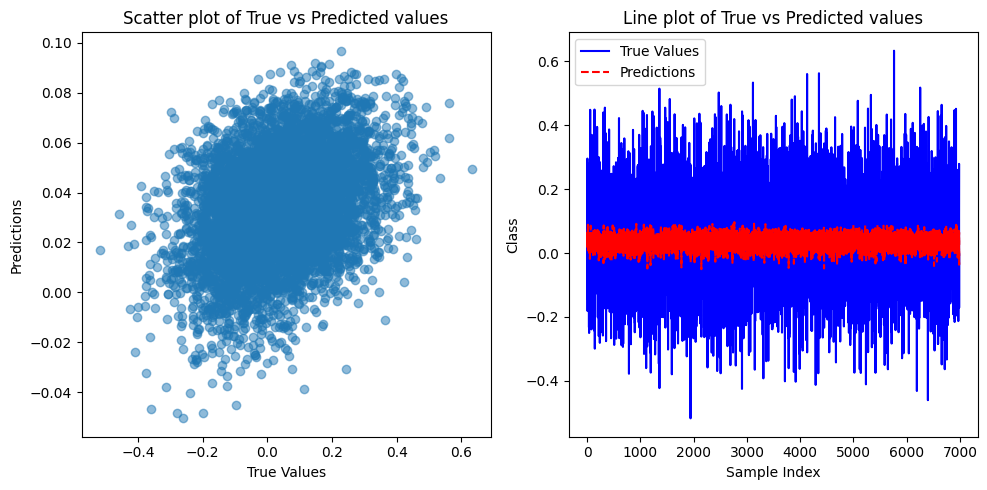

In [ ]:
import matplotlib.pyplot as plt
# Plot y_test vs y_pred
plt.figure(figsize=(10, 5))

# Scatter plot
plt.subplot(1, 2, 1)
plt.scatter(letshopefinal['Perform'], X['Predicted_Perform'], alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Scatter plot of True vs Predicted values")

# Line plot
plt.subplot(1, 2, 2)
plt.plot(letshopefinal['Perform'].values, label='True Values', color='b')
plt.plot(X['Predicted_Perform'], label='Predictions', color='r', linestyle='dashed')
plt.xlabel("Sample Index")
plt.ylabel("Class")
plt.title("Line plot of True vs Predicted values")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Split data for predicting 'Class'
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.25, random_state=42)

# Initialize RandomForestClassifier
rf_model_class = RandomForestClassifier(random_state=42)

# Define larger parameter grid for classification
param_grid_rf_class = {
    'n_estimators': [100]
}

if not pd.api.types.is_numeric_dtype(y_train_class):
    y_train_class = y_train_class.astype(int)
if not pd.api.types.is_numeric_dtype(y_test_class):
    y_test_class = y_test_class.astype(int)

from sklearn.feature_selection import RFECV

grid_rf_class = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf_class, cv=5, n_jobs=-1, scoring= CUSTOM_FEDCSIS_score)

# Fit grid search for classification
grid_rf_class.fit(X_train_class, y_train_class)

# Best estimator for classification
best_rf_class = grid_rf_class.best_estimator_

# Train the best RandomForestClassifier
best_rf_class.fit(X_train_class , y_train_class)

# Predict and evaluate the RandomForestClassifier
y_pred_class = best_rf_class.predict(X_test_class)

# Evaluate the classification model
print(classification_report(y_test_class, y_pred_class))
print(confusion_matrix(y_test_class, y_pred_class))

              precision    recall  f1-score   support

          -1       0.41      0.43      0.42       640
           0       0.29      0.01      0.01       282
           1       0.50      0.64      0.56       825

    accuracy                           0.46      1747
   macro avg       0.40      0.36      0.33      1747
weighted avg       0.43      0.46      0.42      1747

[[277   2 361]
 [106   2 174]
 [291   3 531]]


In [ ]:
# Load and clean test data
test_data = pd.read_csv('/content/test_data_no_target.csv', sep=';')
test_data = test_data.copy()
print(test_data.shape[0])

2000


In [ ]:
def cleantest(data):
    # Replace commas with dots for decimal conversion
    data = data.replace(',', '.', regex=True)

    # Create a new DataFrame by dropping the 'Group' column from the original data
    new_df = data.copy()
    updated_df = new_df.drop(['Group'], axis=1)

    # Convert columns to numeric, coerce errors to NaN
    for column in updated_df.columns:
        updated_df[column] = pd.to_numeric(updated_df[column], errors='coerce', downcast='float')

        # Count NaN values in each column
        na_counts = updated_df[column].isna().sum()

        # Drop columns with more than 1000 NaN values
        if na_counts > 1000:
            updated_df.drop(column, axis=1, inplace=True)

    # Fill NaN values with column means
    na_fill_values = {col: updated_df[col].mean() for col in updated_df.columns if updated_df[col].isna().any()}
    updated_df.fillna(value=na_fill_values, inplace=True)

    resized_df = updated_df.reset_index(drop=True).copy()
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(resized_df)
    scaled_data = pd.DataFrame(scaled_array, columns=resized_df.columns)

    cleaned_df = scaled_data
    return cleaned_df

In [ ]:
cleaned_test_data = cleantest(test_data)
cleaned_test_data = preprocess_features(cleaned_test_data)
final_test_features = cleaned_test_data.drop(['I21', 'I48', 'I50','dI21', 'dI48', 'dI50'], axis=1).copy()
final_test_features = final_test_features.drop(['I1', 'I7', 'I13', 'I33', 'I34', 'dI33', 'Profitability_composite','Operational_efficiency'], axis = 1)
final_test_features['Predicted_Perform'] = ensemble_regressor.predict(final_test_features)
print(final_test_features)

            I2        I3            I4        I5        I6        I8  \
0    -0.057152 -0.049873  1.160712e-01 -0.034568  0.027962 -0.051886   
1    -0.064315 -0.053228 -3.523677e-01  0.081337 -0.231859 -0.058391   
2    -0.062612 -0.048070 -9.274029e-01  0.131322 -1.424172 -0.077541   
3    -0.045437 -0.048436  2.174264e+00 -0.076693  0.001747 -0.056308   
4    -0.037608 -0.042705  1.666769e-03 -0.121262  0.210241 -0.036101   
...        ...       ...           ...       ...       ...       ...   
1995 -0.077786 -0.059643 -5.731314e-01 -0.059105 -0.347976 -0.068335   
1996 -0.049301 -0.050095 -9.918889e-02  0.337958  0.153953 -0.039036   
1997 -0.029548 -0.044566  2.716068e+00  0.053000  0.407882 -0.040399   
1998 -0.052612 -0.054445  2.585337e-09  3.105564  9.386317  0.082210   
1999 -0.040199 -0.044171 -4.178591e-01 -0.269300 -0.197453 -0.057659   

            I9       I10       I11           I12  ...          dI52      dI53  \
0     0.686305 -0.090729  0.083991 -1.775859e-01  ... 

In [ ]:
test_predictions = best_rf_class.predict(final_test_features)
test_predictions = np.clip(test_predictions, -1, 1).astype(int)
# Validate and convert predictions to ensure they are one of {-1, 0, 1}

# Output the predictions to a CSV file as required by the competition
prediction_df = pd.DataFrame(test_predictions, columns=['Prediction'])
prediction_df.to_csv('/content/drive/My Drive/final_challenge/final_predictions_G.txt', index=False, header=False, sep='\t')

print("Predictions saved successfully.")

Predictions saved successfully.


In [ ]:
value_counts = prediction_df['Prediction'].value_counts()

# Print the counts
print("Counts of each prediction category:")
print(value_counts)
print(prediction_df)

Counts of each prediction category:
Prediction
 1    1622
-1     378
Name: count, dtype: int64
      Prediction
0              1
1              1
2              1
3              1
4              1
...          ...
1995           1
1996           1
1997           1
1998           1
1999          -1

[2000 rows x 1 columns]
